# Initialisation du notebook

L'objectif du module est de développer un système de suggestion de tag pour le site Stack Overflow. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.

Ce notebook se consacre à l'exploration et nettoyage des données. 

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold=10

<IPython.core.display.Javascript object>

In [2]:
# -*- coding: utf-8 -*-
%matplotlib inline
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os, pickle, warnings
import datetime as dt
from sklearn.utils import resample
import re, nltk, spacy, gensim
from bs4 import BeautifulSoup
from spacy.lang.en import English
from nltk.corpus import stopwords
from string import punctuation

# Déclaration de variables 

data_path = r"C:\OCR\06 _ Catégorisez automatiquement des questions"
   
pd.options.mode.chained_assignment = None # default='warn'
pd.options.display.max_colwidth = 2000
pd.options.display.float_format = '{:,.2f}'.format
warnings.filterwarnings("ignore")

colors = ['#911eb4', '#f032e6', '0', '#e6beff', '#e6194b', '#fabebe', '#f58231', '#ffe119', 
          '#fffac8', '#bfef45', '#3cb44b', '#aaffc3', '#469990', '#42d4f4', '#4363d8']

# Chargement et découverte des données brutes

In [3]:
all_files = glob.glob(os.path.join(data_path, "QueryResults*.csv")) 

li = []

for absolute_filename in all_files:
    path, file = os.path.split(absolute_filename)
    df = pd.read_csv(absolute_filename, sep=',', encoding='utf-8', engine='python', error_bad_lines=False)
    li.append(df)

df_brut = pd.concat(li, axis=0, ignore_index=True)

print('Taille du CSV importé : {0}'.format(df_brut.shape))

print(pd.DataFrame(df_brut.dtypes, columns=['Type']))

Taille du CSV importé : (91947, 6)
         Type
Id      int64
Name   object
Score   int64
Body   object
Title  object
Tags   object


In [4]:
df_brut.to_pickle("./df_brut.pkl")

Les données extraites ciblent uniquement les posts de type "Question" dont les Id sont compris entre 0 et 600000.

In [3]:
df_brut = pd.read_pickle('./df_brut.pkl')

# Pandas Profiling

In [5]:
profile = df_brut.profile_report(title='Pandas Profiling Report', style={'full_width':True})
profile.to_file(output_file="output.html")

Aucune valeur manquante dans BODY, TITLE et TAGS

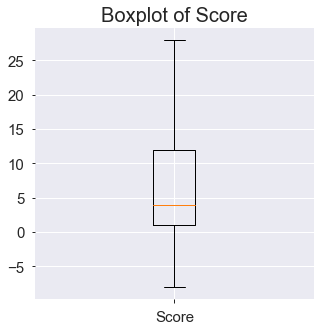

In [6]:
# Boxplot of the variable Score

plt.figure(figsize=(5, 5))
plt.title("Boxplot of Score", fontsize=20)

# Boxplot without showing the outliers 
plt.xticks(size=15)
plt.yticks(size=15)
plot = plt.boxplot(df_brut["Score"], showfliers=False, labels=['Score'])

plt.show()

In [7]:
df_clean1 = df_brut[df_brut.Score >= 3]
print(df_clean1.shape)

(55598, 6)


# Analyse de la variable TAGS

In [8]:
df_clean1['Tags'].head(5)

0    <c#><floating-point><type-conversion><double><decimal>
1                          <html><css><internet-explorer-7>
2                                      <c#><.net><datetime>
3        <c#><datetime><time><datediff><relative-time-span>
4    <html><browser><timezone><user-agent><timezone-offset>
Name: Tags, dtype: object

In [9]:
# création d'un ensemble contenant tous les tags à partir des données du dataframe
# l'avantage d'un ensemble, c'est qu'un élément ne peut s'y trouver que 0 ou 1 fois 

set_tags = set() 

for list_keywords in (df_clean1['Tags'].str.split('>').values):       
    # je rétablis le séparateur utilisé pour séparer les tags
    list_keywords.remove('')
    list_keywords = [keyword[1:] for keyword in list_keywords] 
    set_tags = set_tags.union(list_keywords)

print('There are %d tags' % len(set_tags))

There are 9712 tags


In [10]:
print(sorted(set_tags)[1750:1800])
# D est un langage de programmation

['currying', 'curses', 'cursor', 'cursor-position', 'cursor.current', 'cursors', 'curve', 'curve-fitting', 'curvesmoothing', 'custom-action', 'custom-attributes', 'custom-build-step', 'custom-component', 'custom-controls', 'custom-cursor', 'custom-draw', 'custom-error-pages', 'custom-errors', 'custom-exceptions', 'custom-linq-providers', 'custom-object', 'custom-protocol', 'custom-sections', 'custom-server-controls', 'custom-url-protocol', 'customization', 'custompaging', 'customtool', 'customvalidator', 'cut', 'cvs', 'cwd', 'cx-oracle', 'cxf', 'cycle', 'cyclic-reference', 'cyclomatic-complexity', 'cygwin', 'cython', 'd', 'd-star', 'daab', 'dabo', 'daemon', 'dailybuilds', 'dalvik', 'dao', 'darcs', 'darwin', 'dasblog']


In [50]:
print(sorted(set_tags)[5500:5600])
# nt = windows nt

['nod32', 'node.js', 'nodebox', 'nodelist', 'nodes', 'nodesets', 'nodester', 'nodevalue', 'nofollow', 'nohup', 'nokia', 'nomenclature', 'non-clustered-index', 'non-deterministic', 'non-greedy', 'non-lazy-ptr', 'non-nullable', 'non-printable', 'non-printing-characters', 'non-recursive', 'non-relational-database', 'non-scrolling', 'non-static', 'non-virtual-interface', 'non-well-formed', 'nonatomic', 'nonblank', 'nonblocking', 'nonclient', 'nonlinear-functions', 'normal-distribution', 'normalization', 'normalize', 'normalizing', 'noscript', 'nose', 'nosql', 'nosuchmethoderror', 'not-exists', 'not-operator', 'notation', 'notepad', 'notepad++', 'nothing', 'notification-bar', 'notifications', 'notify', 'notifyicon', 'notimplementedexception', 'notin', 'notnull', 'notsupportedexception', 'novell', 'novell-idm', 'noweb', 'np-complete', 'np-hard', 'npapi', 'nptl', 'nrpe', 'nsarray', 'nsarraycontroller', 'nsautoreleasepool', 'nscell', 'nscoding', 'nsdata', 'nsdate', 'nsdateformatter', 'nsdecima

In [11]:
df_clean1.loc[df_clean1['Tags'].str.contains('<d>')].head(10)

,Id,Name,Score,Body,Title,Tags
5145,47420,Question,3,"<p>I'm using the d programing language to write a program, and I'm trying to use ddbg to debug it. When there is an exception, I want to have the program break whenever there is an exception thrown so that I can inspect the stack.</p>\n\n<p>Alternatively, is there another debugger that works with d? Is there another way to get a stack trace when there is an exception?</p>\n",How can I break on exception using ddbg,<d>
9336,472133,Question,24,"<p>I'm a C++ programmer thats considering using D for a personal project I want to play around with. I was wondering if there's a way to completely disable the garbage collector, and what the risks are of doing so. </p>\n\n<p>I know I can manage my own memory by overriding new and delete to use malloc and free, but if I did that I'd rather the garbage collector not run at all.</p>\n",Turning off the D garbage collector,<memory><memory-management><d><garbage-collection>
15091,506093,Question,36,"<p>I'm working on a custom mark-release style memory allocator for the D programming language that works by allocating from thread-local regions. It seems that the thread local storage bottleneck is causing a huge (~50%) slowdown in allocating memory from these regions compared to an otherwise identical single threaded version of the code, even after designing my code to have only one TLS lookup per allocation/deallocation. This is based on allocating/freeing memory a large number of times in a loop, and I'm trying to figure out if it's an artifact of my benchmarking method. My understanding is that thread local storage should basically just involve accessing something through an extra layer of indirection, similar to accessing a variable via a pointer. Is this incorrect? How much overhead does thread-local storage typically have?</p>\n\n<p>Note: Although I mention D, I'm also interested in general answers that aren't specific to D, since D's implementation of thread-local storage will likely improve if it is slower than the best implementations.</p>\n",Why is thread local storage so slow?,<multithreading><performance><d><thread-local-storage>
18400,525123,Question,11,"<p><strong>Background:</strong> I'm trying to create a pure D language implementation of functionality that's roughly equivalent to <a href=""http://en.cppreference.com/w/c/string/byte/memchr"" rel=""noreferrer"">C's memchr</a> but uses arrays and indices instead of pointers. The reason is so that std.string will work with compile time function evaluation. For those of you unfamiliar w/ D, functions can be evaluated at compile time if certain restrictions are met. One restriction is that they can't use pointers. Another is that they can't call C functions or use inline assembly language. Having the string library work at compile time is useful for some compile time code gen hacks.</p>\n\n<p><strong>Question:</strong> How does memchr work under the hood to perform as fast as it does? On Win32, anything that I've been able to create in pure D using simple loops is at least 2x slower even w/ obvious optimization techniques such as disabling bounds checking, loop unrolling, etc. What kinds of non-obvious tricks are available for something as simple as finding a character in a string?</p>\n",How does memchr() work under the hood?,<c><performance><d><standard-library>
20945,539234,Question,14,"<p>I'm curious: has anyone used D together with .NET languages? Is that even possible? What kind of stuff is easier/makes sense to do in D that's hard to do in, say, C++/CLI?</p>\n",Using D programming language in a .NET context,<.net><interop><d>
24157,557011,Question,7,"<p>This may sound really stupid. but I've got a strange problem with the D programming language. When I try to create a new array like this:</p>\n\n<pre><code>import std.stdio;\n\nvoid main()\n{\n char[] variable = ""value"";\n writefln(variable);\n}\n</code></pre>\n\n<p>The DMD compiler always gives me this error:</p>\n\n<blockq

In [12]:
# je compte les occurrences de chaque tag dans le dataframe
keyword_count = dict()
for s in set_tags: 
    #print(s)
    keyword_count[s] = df_clean1.Tags.str.count(re.escape(s)).sum() 

In [13]:
sorted_keyword_count = sorted(keyword_count.items(), key=lambda x: x[1], reverse=True)

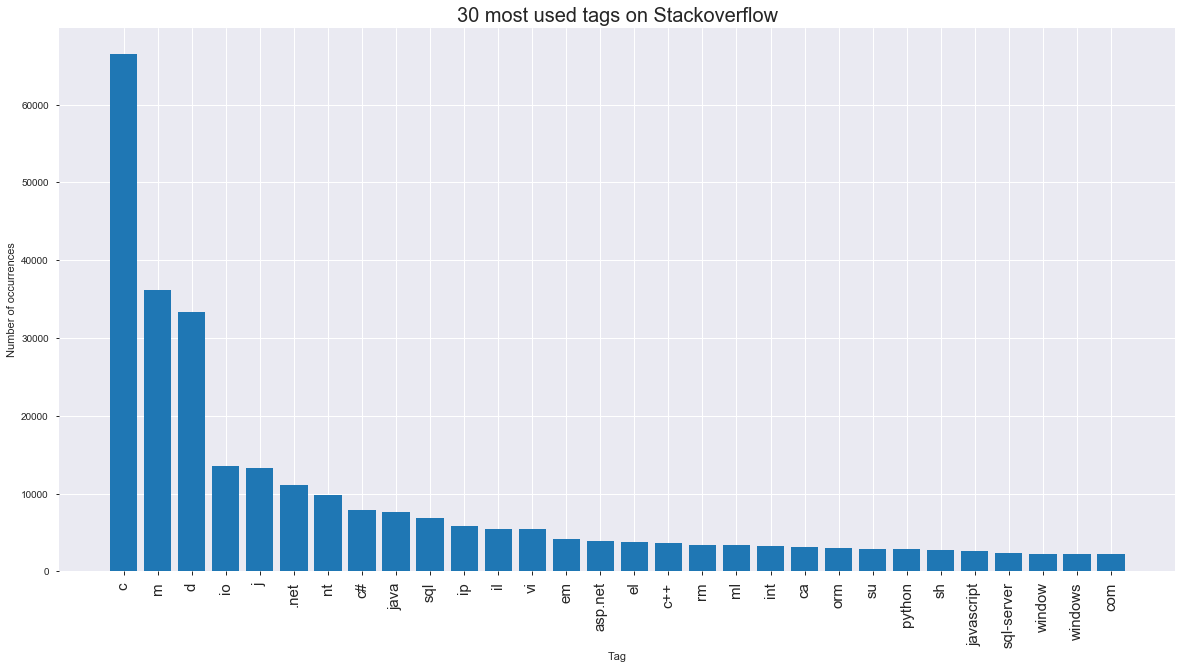

In [14]:
# Graphique des 30 tags les plus utilisés sur Stackoverflow

top30tags = sorted_keyword_count[1:31]

plt.figure(figsize=(20, 10))
y_axis = [i[1] for i in top30tags]
label_x = [i[0] for i in top30tags]
plt.xticks(rotation=90, fontsize=15)
ax = plt.axes()
ax = ax.set(xlabel="Tag", ylabel="Number of occurrences")

plt.bar(label_x, y_axis)
plt.title("30 most used tags on Stackoverflow",fontsize=20)
plt.show()

In [15]:
nb_posts_targeted = dict() 

for nb_top_tags in np.linspace(100, 1000, 10, dtype='int'):

    top_tags = [i[0] for i in sorted_keyword_count[1:nb_top_tags+1]]
    nb_posts_targeted[nb_top_tags] = 0
    
    for tags in df_clean1.Tags.str.split('>'):
        tags.remove('')
        tags = [tag[1:] for tag in tags] 
        for tag in tags:
            if tag in top_tags:
                nb_posts_targeted[nb_top_tags] += 1
                break

    percentage_posts = (nb_posts_targeted[nb_top_tags]/df_clean1.shape[0])*100
    print('With %d tags kept, %.2f %% of the posts are concerned ' % (nb_top_tags, percentage_posts))                        

With 100 tags kept, 74.32 % of the posts are concerned 
With 200 tags kept, 85.36 % of the posts are concerned 
With 300 tags kept, 89.90 % of the posts are concerned 
With 400 tags kept, 92.83 % of the posts are concerned 
With 500 tags kept, 94.19 % of the posts are concerned 
With 600 tags kept, 95.16 % of the posts are concerned 
With 700 tags kept, 96.18 % of the posts are concerned 
With 800 tags kept, 96.84 % of the posts are concerned 
With 900 tags kept, 97.26 % of the posts are concerned 
With 1000 tags kept, 97.62 % of the posts are concerned 


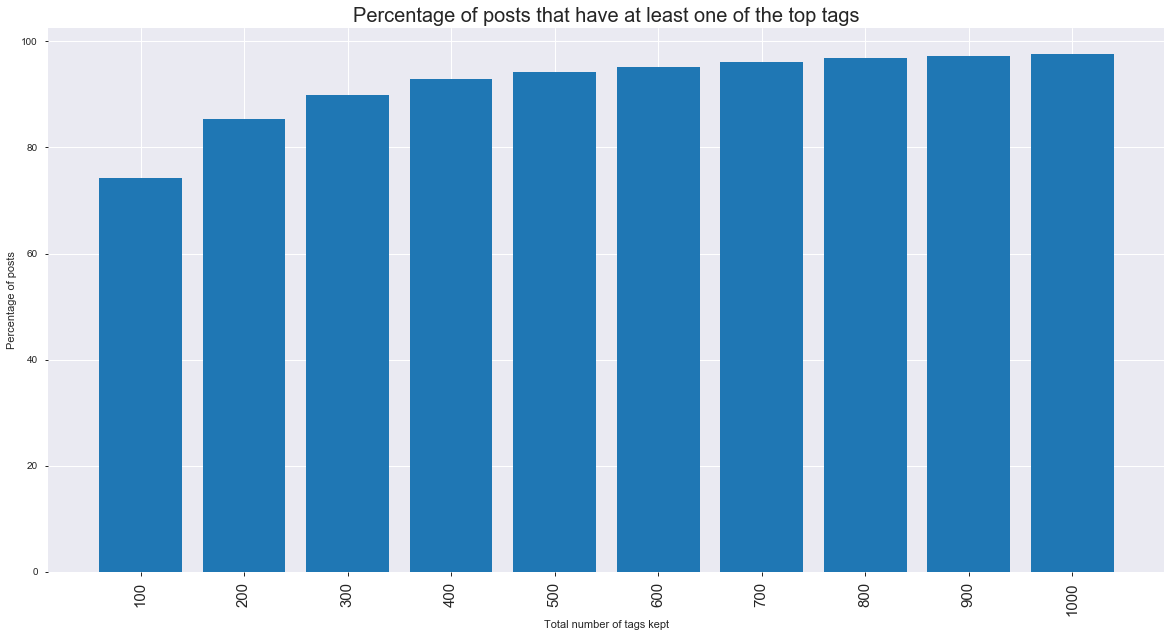

In [16]:
# Graphiques représentant le pourcentage de posts qui ont au moins un des top tags

plt.figure(figsize=(20, 10))
y_axis = [nb_posts_targeted[i]/df_clean1.shape[0]*100 for i in np.arange(100,1100, 100)]
label_x = [str(i) for i in np.arange(100,1100, 100)]
plt.xticks(rotation=90, fontsize=15)
ax = plt.axes()
ax = ax.set(xlabel="Total number of tags kept", ylabel="Percentage of posts")
plt.title("Percentage of posts that have at least one of the top tags",fontsize=20)
plt.bar(label_x, y_axis)
plt.show()

In [17]:
nb_posts_targeted = dict() 

for nb_top_tags in np.linspace(10, 100, 10, dtype='int'):

    top_tags = [i[0] for i in sorted_keyword_count[1:nb_top_tags+1]]
    nb_posts_targeted[nb_top_tags] = 0
    
    for tags in df_clean1.Tags.str.split('>'):
        tags.remove('')
        tags = [tag[1:] for tag in tags]        
        for tag in tags:
            if tag in top_tags:
                nb_posts_targeted[nb_top_tags] += 1
                break

    percentage_posts = (nb_posts_targeted[nb_top_tags]/df_clean1.shape[0])*100
    print('With %d tags kept, %.2f %% of the posts are concerned ' % (nb_top_tags, percentage_posts))                        

With 10 tags kept, 32.79 % of the posts are concerned 
With 20 tags kept, 41.04 % of the posts are concerned 
With 30 tags kept, 53.19 % of the posts are concerned 
With 40 tags kept, 60.47 % of the posts are concerned 
With 50 tags kept, 62.75 % of the posts are concerned 
With 60 tags kept, 64.43 % of the posts are concerned 
With 70 tags kept, 67.63 % of the posts are concerned 
With 80 tags kept, 69.66 % of the posts are concerned 
With 90 tags kept, 72.50 % of the posts are concerned 
With 100 tags kept, 74.32 % of the posts are concerned 


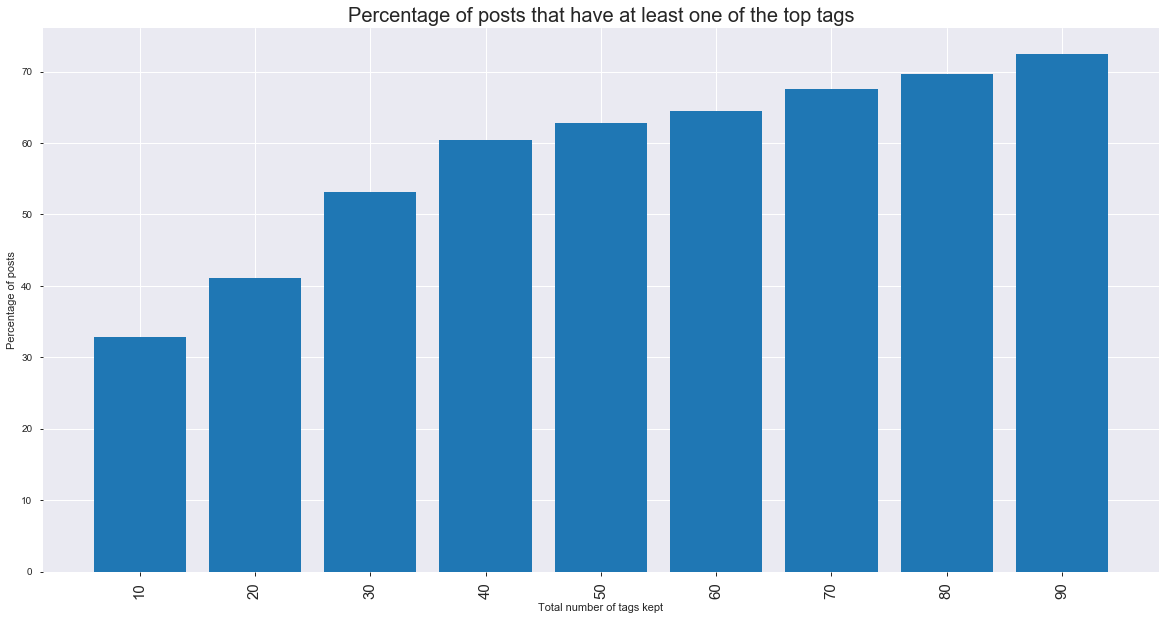

In [18]:
# Graphiques représentant le pourcentage de posts qui ont au moins un des top tags

plt.figure(figsize=(20, 10))
y_axis = [nb_posts_targeted[i]/df_clean1.shape[0]*100 for i in np.arange(10,100, 10)]
label_x = [str(i) for i in np.arange(10,100, 10)]
plt.xticks(rotation=90, fontsize=15)
ax = plt.axes()
ax = ax.set(xlabel="Total number of tags kept", ylabel="Percentage of posts")
plt.title("Percentage of posts that have at least one of the top tags",fontsize=20)
plt.bar(label_x, y_axis)
plt.show()

In [19]:
def most_common(tags, top_tags):
    ''' keep only the tags that are part of the top most used tags on StackOverflow

    tags: tags associated to post
    '''
    
    clean_tags = tags.split('>')
    clean_tags.remove('')
    clean_tags = [tag[1:] for tag in clean_tags]     
    tags_filtered = []
    
    for tag in clean_tags:
        if tag in top_tags:            
            tags_filtered.append(tag)
            
    return tags_filtered

In [20]:
# I decided to keep the 100 most popular tags because they represent almost 75%
# of all the posts, and also because it'll be easier to predict the right tags
# from 100 words than from 10,000 and because we want to keep macro tags and 
# not be too specific since it's only a recommendation for a post

top100tags = [i[0] for i in sorted_keyword_count[1:101]]

print('Taille du dataframe avant : {0}'.format(df_clean1.shape))

df_clean2 = df_clean1.copy()
df_clean2['Tags'] = df_clean2['Tags'].apply(lambda x: most_common(x, top100tags))
df_clean2['Tags'] = df_clean2['Tags'].apply(lambda x: x if len(x)>0 else None)
df_clean2.dropna(subset=['Tags'], inplace=True)
df_clean2 = df_clean2[['Tags', 'Body']]

print('Taille du dataframe après : {0}'.format(df_clean2.shape))

Taille du dataframe avant : (55598, 6)
Taille du dataframe après : (41322, 2)


In [21]:
# SAUVEGARDE
with open('top100tags.pkl', 'wb') as f:
    pickle.dump(top100tags, f)

df_clean1.to_pickle("./df_clean1.pkl")
df_clean2.to_pickle("./df_clean2.pkl")

In [376]:
# CHARGEMENT
with open('top100tags.pkl', 'rb') as f:
    top100tags = pickle.load(f)    

df_clean1 = pd.read_pickle('./df_clean1.pkl')
df_clean2 = pd.read_pickle('./df_clean2.pkl')

# Nettoyage du jeu de données

- Suppression des postes dont le score est inférieur à 3
- Conservation des postes dont les tags sont dans le top 100 et suppression des tags hors top 100
- Suppression du format html avec le package Beautiful Soup 
- Mise en minuscules du texte 
- Transformations des abréviations
- Suppression des stop words 
- Lemmatisation
- Suppression des verbes et adjectifs qui n'apportent de valeur ajoutée pour ce que je souhaite faire

In [22]:
few_posts = resample(df_clean2['Body'], n_samples=10, random_state=0)

In [23]:
def clean_text(text):
    ''' Lowering text and removing undesirable marks
    '''
    
    text = text.lower()
    text = re.sub(r"\'\n", " ", text) # removes line feeds
    text = re.sub(r"\'\xa0", " ", text) # removes spaces
    text = re.sub('\s+', ' ', text) # matches all whitespace characters : \t\n\r\f\v
    text = text.strip(' ') # removes leading and trailing blanks
    return text

In [24]:
df_clean2['Body_proper1'] = df_clean2['Body'].apply(lambda x: clean_text(x))

# the text of the post, without tags or markup
df_clean2['Body_proper2'] = df_clean2['Body_proper1'].apply(lambda x: BeautifulSoup(x).get_text())

In [25]:
# avant nettoyage
df_clean2.loc[few_posts.index]['Body'].sort_index()

4320                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        <p>If I have an HTML helper like so:</p>\n\n<pre><code>Name:

In [26]:
# après nettoyage
df_clean2.loc[few_posts.index]['Body_proper2'].sort_index()

4320                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          if i have an html helper like so: name:<br /> <%=html.text

In [97]:
nlp = English()
# Create a Tokenizer with the default settings for English
# including punctuation rules and exceptions
spacy_tokenizer = nlp.Defaults.create_tokenizer(nlp)
# Spacy va permettre de gérer ce genre de cas : i'm having issues. 
# Plutôt de renvoyer "i", "m", Spacy va renvoyer "i", "'m"
# tokens = tokenizer("i'm having issues")
punct = punctuation
top_tags = []

def clean_punctuation(text, top_tags): 
    ''' Remove punctuation'''

    words = spacy_tokenizer(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punct))
    
    for w in words:
        # certains mots peuvent être des tags qui contiennent des signes de ponctuation, il faut les conserver tels quels
        if str(w) in top_tags: 
            punctuation_filtered.append('<' + str(w) + '>')
        else:
            w = re.sub('[0-9]', ' ', str(w)) # word contains no digits
            punctuation_filtered.append(regex.sub(' ', str(w)))
        
    result = ' '.join(punctuation_filtered)
    result = re.sub(' +', ' ', result) # remove duplicates whitespaces
    return result 

In [99]:
df_clean2['Body_proper3'] = df_clean2['Body_proper2'].apply(lambda x: clean_punctuation(x, top100tags)) 

In [100]:
# après nettoyage
df_clean2.loc[few_posts.index]['Body_proper3'].sort_index()

4320                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                if i have an <html> helper like so name br html text

In [101]:
print(df_clean2['Body_proper3'].loc[df_clean2['Tags'].str.join(',').str.contains(re.escape('c++'))].head(1))
print(df_clean2['Body'].loc[df_clean2['Tags'].str.join(',').str.contains(re.escape('c++'))].head(1))

10    i m having issues getting the <c> sockets <api> to work properly in <c++> on z os although i am including sys socket h i still get compile <time> errors telling me that af inet is not defined am i missing something obvious or is this related to the fact that being on z os makes my problems much more complicated update upon further investigation i discovered that there is an ifdef that i m hitting apparently z os is n t happy unless i define which type of sockets i m using with define oe sockets now i personally have no idea what this oe sockets is actually for so if any z os sockets programmers are out there all of you perhaps you could give me a rundown of how this all works test app include sys socket h <int> main return af inet compile link output cxx wc xplink wl xplink o inet test inet c inet c line ccn s the name lookup for af inet did not find a declaration ccn i compilation failed for <file> inet c <object> <file> not created a check of sys sockets h does include the defi

In [102]:
stop_words = list(set(nlp.Defaults.stop_words) | set(stopwords.words("english")))

def stopWordsRemove(text):
    ''' Removing all the english stop words from a corpus
    Parameter:
    text: corpus to remove stop words from it
    '''

    words = spacy_tokenizer(text)
    filtered = [str(w) for w in words if not str(w) in stop_words]
    
    return ' '.join(map(str, filtered))

# no recognition of dependency labels and named entities 
nlp = spacy.load('en', disable=['parser', 'ner'])
print(nlp.pipe_names)

def lemmatization(text_in, top_tags, allowed_postags, stop_words=stop_words):
    ''' It keeps the lemma of the words (lemma is the uninflected form of a word),
    and deletes the undesired POS tags
    
    Parameters:
    
    text_in (list): text to lemmatize
    allowed_postags (list): list of allowed postags, like NOUN, ADJ, VERB, ADV
    '''
    doc = nlp(text_in) 
    text_out = []
    
    for token in doc:
        
        if str(token) in top_tags:
            text_out.append(str(token))
            
        elif token.pos_ in allowed_postags:            
            text_out.append(token.lemma_)
                
    text_out = ' '.join(text_out)

    return text_out

['tagger']


In [103]:
df_clean2['Body_proper4'] = df_clean2['Body_proper3'].apply(lambda x: stopWordsRemove(x)) 
df_clean2['Body_proper5'] = df_clean2['Body_proper4'].apply(lambda x: lemmatization(x, top100tags, ['NOUN']))
# There are a lot of verbs and adjectives (ex: like, use, get, new) and they don't give
# interesting informations about the contents of the question

In [104]:
# après nettoyage
df_clean2.loc[few_posts.index]['Body_proper5'].sort_index()

4320                                                                                                                                                                                                                                                                                           html helper html css class wrap span utilize property helper
33352                                                                                                                       challenge skill object programming idea poll idea oop use library library challenge answer vote correspond merit level skill exercise solution challenge answer example challenge stack skill level experience reference object
33897                                                                                                                                                                                                                                                                      time c year web application programmi

In [105]:
print(df_clean2['Body_proper5'].loc[df_clean2['Tags'].str.join(',').str.contains(re.escape('c++'))].head(1))

10    issue c api work c++ compile time error fact problem update investigation ifdef define type socket socket socket work app int return inet compile link output cxx c c line declaration compilation file inet c object file check socket definition ifdef statement ifdef cplusplus c encapsulate file matter
Name: Body_proper5, dtype: object


In [78]:
doc = nlp("successfully")
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_, token.shape_, token.is_alpha, token.is_stop)

successfully successfully ADV RB  xxxx True False


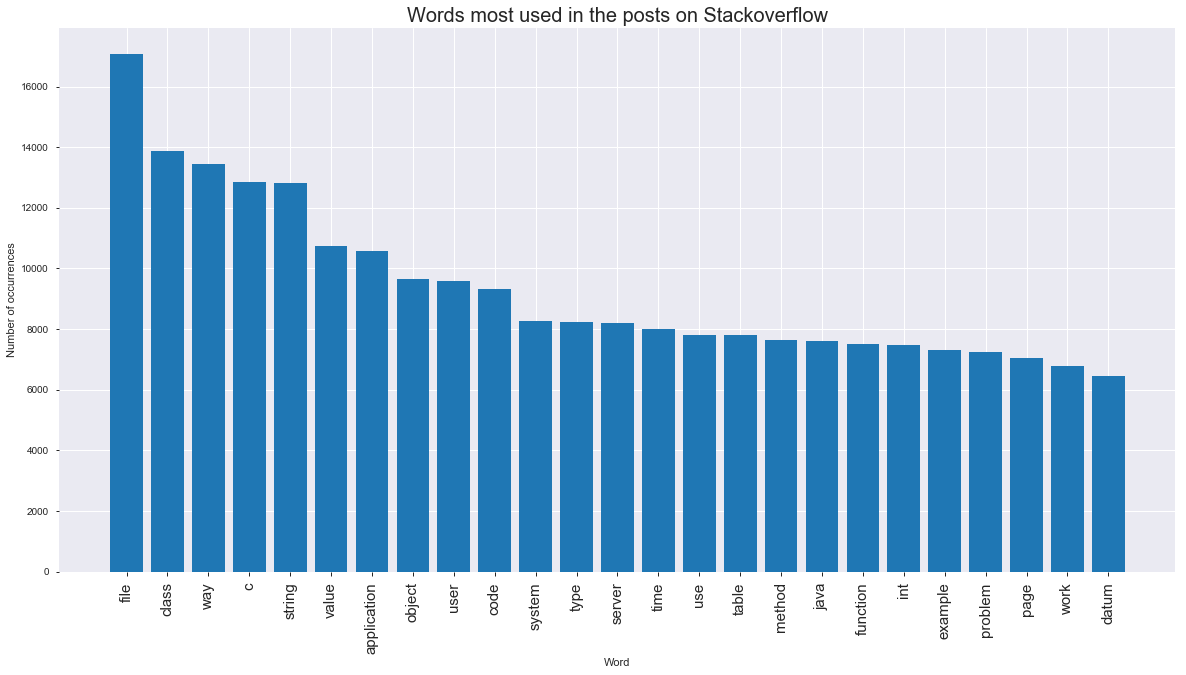

In [106]:
# Graph showing the words most used in the post on Stackoverflow

txt = df_clean2['Body_proper5'].str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
word_dist = nltk.FreqDist(words)
result = pd.DataFrame(word_dist.most_common(25),columns=['Word','Frequency'])

plt.figure(figsize=(20, 10))
plt.xticks(rotation=90, fontsize=15)
ax = plt.axes()
ax = ax.set(xlabel="Word", ylabel="Number of occurrences")

plt.bar(result.Word, result.Frequency)
plt.title("Words most used in the posts on Stackoverflow",fontsize=20)
plt.show()

In [107]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler

In [113]:
# Binarizing the tags for the supervised models
multilabel_binarizer = MultiLabelBinarizer()
Y_target = multilabel_binarizer.fit_transform(df_clean2['Tags'])

# 80/20 split
X_train, X_test, Y_train, Y_test = train_test_split(df_clean2['Body_proper5'], 
                                                    Y_target, 
                                                    test_size=0.2, train_size=0.8, random_state=42)

vectorizer_X = TfidfVectorizer(analyzer='word', min_df=0.0, max_df = 1.0, 
                               encoding='utf-8',                                
                               max_features=500)

# TF-IDF matrices
X_tfidf_train = vectorizer_X.fit_transform(X_train)
X_tfidf_test = vectorizer_X.transform(X_test)

In [114]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

Extracting topics from LDA...


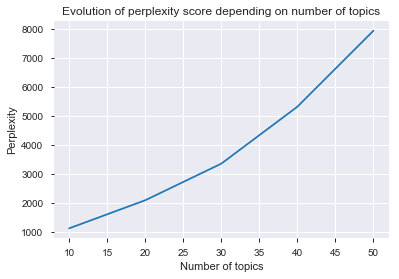

In [115]:
best_perplexity = np.inf
best_lda = 0
perplexity_list = []
n_topics_list = []
print("Extracting topics from LDA...")

# number of topics 
for n_topics in np.linspace(10, 50, 5, dtype='int'):
    lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                          learning_method='online',
                                          learning_offset=50.,
                                          random_state=42).fit(X_tfidf_train)
    n_topics_list.append(n_topics)
    perplexity = lda_model.perplexity(X_tfidf_test)
    perplexity_list.append(perplexity)

    # Perplexity is defined as exp(-1. * log-likelihood per word)
    # Perplexity: The smaller the better
    if perplexity <= best_perplexity:
        best_perplexity = perplexity
        best_lda = lda_model
                                
plt.title("Evolution of perplexity score depending on number of topics")
plt.xlabel("Number of topics")
plt.ylabel("Perplexity")
plt.plot(n_topics_list, perplexity_list)
plt.show()

In [116]:
n_top_words = 15
display_topics(best_lda, vectorizer_X.get_feature_names(), n_top_words)

Topic 0:
class int object method function type string value return exception interface property code way error
Topic 1:
string list item value number character way array algorithm difference expression example function word element
Topic 2:
file python xml php path line way directory output document string config folder print script
Topic 3:
java project file library windows studio application version source program linux tool code assembly system
Topic 4:
thread view bar session model request foo action user controller domain entity person page object
Topic 5:
table sql database column mysql server row query datum record procedure linq field value way
Topic 6:
net web application asp service site iphone framework use windows user server language app project
Topic 7:
page image javascript html text jquery control event form css window button element style user
Topic 8:
test unit testing ruby self method code class card flag module plugin editor end container
Topic 9:
server svn file cl

In [ ]:
#0 interface graphique
#1 programmation objet (base)
#2 back end
#3 ?
#4 ?
#5 développement web
#6 programmation objet (interface)
#7 scripting
#8 développement HTML
#9 requêtage database

In [164]:
import pyLDAvis.sklearn
 
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda, X_tfidf_test, vectorizer_X, mds='tsne')
panel

PreparedData(topic_coordinates=           x       y  topics  cluster  Freq
topic                                      
3      59.59    5.45       1        1 17.16
6     -20.29    0.99       2        1 13.29
5     -47.82 -136.52       3        1 11.69
4      22.43  -42.22       4        1 10.72
2      99.15  -52.85       5        1 10.54
0     -58.27  -57.33       6        1 10.28
1      51.17  -93.39       7        1  9.17
7      23.90 -154.38       8        1  8.08
8      -7.45  -92.62       9        1  5.07
9      96.29 -132.16      10        1  4.00, topic_info=    Category   Freq              Term  Total  loglift  logprob
336  Default 425.00              file 425.00    30.00    30.00
425  Default 156.00             image 156.00    29.00    29.00
883  Default 179.00             table 179.00    28.00    28.00
908  Default 106.00            thread 106.00    27.00    27.00
494  Default 168.00              line 168.00    26.00    26.00
145  Default  71.00             color  71.00    25.00    25.00
149  Default 105.00           command 105.00    24.00    24.00
771  Default 123.00            script 123.00    23.00    23.00
216  Default 147.00          database 147.00    22.00    22.00
146  Default  91.00            column  91.00    21.00    21.00
603  Default 178.00              page 178.00    20.00    20.00
597  Default  95.00            output  95.00    19.00    19.00
690  Default 186.00           project 186.00    18.00    18.00
135  Default 258.00             class 258.00    17.00    17.00
368  Default  44.00              game  44.00    16.00    16.00
855  Default 206.00            string 206.00    15.00    15.00
618  Default  80.00              path  80.00    14.00    14.00
671  Default  64.00             print  64.00    13.00    13.00
787  Default 217.00            server 217.00    12.00    12.00
684  Default 125.00           program 125.00    11.00    11.00
253  Default  84.00         directory  84.00    10.00    10.00
896  Default 144.00              text 144.00     9.00     9.00
185  Default 128.00           control 128.00     8.00     8.00
700  Default  72.00             query  72.00     7.00     7.00
68   Default  54.00        background  54.00     6.00     6.00
833  Default  70.00               sql  70.00     5.00     5.00
809  Default  73.00              size  73.00     4.00     4.00
755  Default  67.00               row  67.00     3.00     3.00
788  Default  98.00           service  98.00     2.00     2.00
979  Default 155.00            window 155.00     1.00     1.00
856   Topic1  20.36            struct  20.61     1.75    -5.65
44    Topic1  15.80               arg  16.05     1.75    -5.90
846   Topic1  14.39               std  14.63     1.75    -5.99
175   Topic1  12.66             const  12.90     1.74    -6.12
369   Topic1  10.82           garbage  11.06     1.74    -6.28
560   Topic1   8.09           myclass   8.33     1.73    -6.57
75    Topic1   7.59              bean   7.84     1.73    -6.63
53    Topic1   7.47        assignment   7.72     1.73    -6.65
587   Topic1  28.07          operator  29.03     1.73    -5.32
240   Topic1   6.88        destructor   7.13     1.73    -6.73
881   Topic1   6.73  systemoutprintln   6.98     1.73    -6.75
785   Topic1   6.51     serialization   6.76     1.73    -6.79
469   Topic1  17.99           keyword  18.67     1.73    -5.77
188   Topic1  13.89        conversion  14.44     1.72    -6.03
951   Topic1   5.93               val   6.18     1.72    -6.88
461   Topic1  10.46          iterator  10.93     1.72    -6.31
722   Topic1  13.47        reflection  14.11     1.72    -6.06
106   Topic1   6.91             byval   7.34     1.70    -6.73
178   Topic1  29.96       constructor  32.03     1.70    -5.26
90    Topic1   9.14              bool   9.80     1.69    -6.45
30    Topic1   7.01        annotation   7.52     1.69    -6.71
375   Topic1   7.26           generic   7.82     1.69    -6.68
356   Topic1   9.07           foreach   9.78     1.69    -6.45
607   Topic1  16.03        

In [121]:
with open('best_lda.pkl', 'wb') as f:
    pickle.dump(best_lda, f)

In [17]:
with open('best_lda.pkl', 'rb') as f:
    best_lda = pickle.load(f)    

In [134]:
vectorizer_X = TfidfVectorizer(analyzer='word', min_df=0.0, max_df = 1.0, 
                               encoding='utf-8',                                
                               max_features=5)

# TF-IDF matrices
X_tfidf_train = vectorizer_X.fit_transform(X_train)
X_tfidf_test = vectorizer_X.transform(X_test)

lda_model = LatentDirichletAllocation(n_components=2, max_iter=5,
                                      learning_method='online',
                                      learning_offset=50.,
                                      random_state=42).fit(X_tfidf_train)


proba_topic_sachant_text = lda_model.transform(X_tfidf_test)
feature_names = vectorizer_X.get_feature_names()
proba_tag_sachant_topic = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis] # normalization    
print(proba_topic_sachant_text.shape)
print(proba_tag_sachant_topic.shape)

(8265, 2)
(2, 5)


In [135]:
mult = proba_topic_sachant_text.dot(proba_tag_sachant_topic)
print(mult[0])

[0.18787094 0.21819323 0.16399752 0.14814547 0.28179283]


In [136]:
proba_topic_sachant_text[0]

array([0.5, 0.5])

In [138]:
proba_tag_sachant_topic[1]

array([3.75691866e-01, 5.90450177e-05, 3.27945085e-01, 2.96241372e-01,
       6.26325405e-05])

In [128]:
def Recommend_tags_lda(text, n_tags, clean=False):
    
    ''' Recommendation system for StackOverflow posts based on a lda model, it returns up to 5 tags.

    Parameters:

    text: the stackoverflow post of user
    n_tags: number of tags to recommend
    clean: True if data preparation is needed
    '''
    if type(text) in (str, pd.Series):
        if type(text) is str:
            text = pd.Series(text) 
            type_text = 'str'
        else:
            type_text = 'pd.Series'
            result = pd.Series(text).reset_index(drop=True)
    else:
        return 'Type should be str or pd.Series'

    if clean==True:
        text = text.apply(lambda x: clean_text(x))
        text = text.apply(lambda x: BeautifulSoup(x).get_text())
        text = text.apply(lambda x: clean_punctuation(x))
        text = text.apply(lambda x: stopWordsRemove(x)) 
        text = text.apply(lambda x: lemmatization(x, ['NOUN']))    
        
    all_tags_scores = dict()
    
    text_tfidf = vectorizer_X.transform(text)
    proba_topic_sachant_text = best_lda.transform(text_tfidf)
    feature_names = vectorizer_X.get_feature_names()
    proba_tag_sachant_topic = best_lda.components_ / best_lda.components_.sum(axis=1)[:, np.newaxis] # normalization    
    #print(proba_topic_sachant_text.shape)    
    #print(proba_tag_sachant_topic.shape)    
    
    #for id_text, value in text.items(): # j'itère sur les documents
    for id_text in range(proba_topic_sachant_text.shape[0]): # nombre de documents 
        all_tags_scores = dict()

        for id_topic in range(proba_topic_sachant_text.shape[1]): # nombre de topics  
            # j'itère sur les topics pour récupérer la probabilité que le topic soit associé au document
            topic_score = proba_topic_sachant_text[id_text][id_topic]
            #print(topic_score)
            # [::-1] reverses the array returned by argsort() and [:n] gives that last n element
            # les proba sont classées par ordre croissant, je récupère les N indices des tags ayant les plus fortes proba
            tags_id = proba_tag_sachant_topic[id_topic].argsort()[::-1][:n_tags]
            # et les N plus fortes proba
            tags_score = sorted(proba_tag_sachant_topic[id_topic], reverse=True)[:n_tags]
            for id_tag in range(n_tags): 
                # j'itère sur les tags pour récupérer la probabilité que le tag apparaisse dans le topic
                #print(id_text, id_topic, topic_score, tags_id[id_tag], tags_score[id_tag])
                # le score est la probabilité que le topic soit associé au document 
                # multiplié par la probabilité que le tag apparaisse dans le topic
                tag_score = topic_score * tags_score[id_tag]
                #print(tag_score, feature_names[tags_id[id_tag]])
                if feature_names[tags_id[id_tag]] in all_tags_scores:
                    # si le tag est déjà présent, je conserve la proba la plus élevée
                    if tag_score > all_tags_scores[feature_names[tags_id[id_tag]]]:
                        all_tags_scores[feature_names[tags_id[id_tag]]] = tag_score
                else:
                    all_tags_scores[feature_names[tags_id[id_tag]]] = tag_score
    
        #tags_recommended = sorted(all_tags_scores.items(), key=lambda x:x[1], reverse=True)[:5]
        #print(tags_recommended)
        #my_new_list = [key for key, value in my_list]
        tags_recommended = sorted(all_tags_scores, key=all_tags_scores.get, reverse=True)[:5]        
        tags_recommended = " ".join(tags_recommended)
        if type_text == 'pd.Series':
            result[id_text] = tags_recommended
        else:
            result = tags_recommended
            
    if type_text == 'pd.Series': 
        result.index = text.index
       
    return result

In [127]:
#dépendances : top500 tags, stopWordsRemove 
df_clean2 = pd.read_pickle('./df_clean2.pkl')
with open('best_lda.pkl', 'rb') as f:
    best_lda = pickle.load(f)    
with open('top500tags.pkl', 'rb') as f:
    top500tags = pickle.load(f)       

test = df_clean2['Body'].loc[3:5]
#test = X_test[:2]
print(test)
Recommend_tags_lda(test, 5) #, clean=True)

3    <p>Given a specific <code>DateTime</code> value, how do I display relative time, like:</p>\n\n<u...
4    <p>Is there a standard way for a web server to be able to determine a user's timezone within a w...
5    <p>What is the difference between <a href="http://msdn.microsoft.com/en-us/library/9a6a2sxy.aspx...
Name: Body, dtype: object
(3, 10)
(10, 1000)


3           table database column datum query
4        page server service thread exception
5    server service thread exception language
Name: Body, dtype: object

In [314]:
with open('best_lda.pkl', 'rb') as f:
    best_lda = pickle.load(f)    

In [319]:
proba_topic_sachant_text = best_lda.transform(text_tfidf)
1x10

proba_tag_sachant_topic = best_lda.components_ / best_lda.components_.sum(axis=1)[:, np.newaxis] # normalization    
10x1000

1x1000
pour 1000 cellules = somme (proba_topic_sachant_text x proba_tag_sachant_topic)
top 5 (proba_topic_sachant_text x proba_tag_sachant_topic)


# en transposant cette matrice puis en multipliant par proba_topic

NameError: name 'proba_topic_sachant_text' is not defined

In [318]:
best_lda.transform('Given a specific DateTime value, how do I display')

ValueError: Expected 2D array, got scalar array instead:
array=Given a specific DateTime value, how do I display.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [132]:
df_clean2['Tags'].loc[3:5]

3               [<datetime>, <time>]
4    [<html>, <browser>, <timezone>]
5                   [<.net>, <math>]
Name: Tags, dtype: object

In [145]:
top500tags

['<.net>',
 '<java>',
 '<c++>',
 '<asp.net>',
 '<python>',
 '<javascript>',
 '<php>',
 '<sql>',
 '<sql-server>',
 '<windows>',
 '<c>',
 '<html>',
 '<visual-studio>',
 '<database>',
 '<jquery>',
 '<mysql>',
 '<ruby>',
 '<css>',
 '<asp.net-mvc>',
 '<performance>',
 '<wpf>',
 '<linux>',
 '<winforms>',
 '<xml>',
 '<ruby-on-rails>',
 '<svn>',
 '<iphone>',
 '<algorithm>',
 '<unit-testing>',
 '<language-agnostic>',
 '<regex>',
 '<vb.net>',
 '<multithreading>',
 '<perl>',
 '<visual-studio-2008>',
 '<string>',
 '<linq>',
 '<version-control>',
 '<security>',
 '<oop>',
 '<delphi>',
 '<user-interface>',
 '<eclipse>',
 '<debugging>',
 '<oracle>',
 '<objective-c>',
 '<macos>',
 '<winapi>',
 '<ajax>',
 '<web-services>',
 '<cocoa-touch>',
 '<sql-server-2005>',
 '<wcf>',
 '<design-patterns>',
 '<arrays>',
 '<django>',
 '<cocoa>',
 '<testing>',
 '<exception>',
 '<generics>',
 '<tsql>',
 '<linq-to-sql>',
 '<optimization>',
 '<file>',
 '<apache-flex>',
 '<git>',
 '<excel>',
 '<unix>',
 '<sharepoint>',
 '<

In [130]:
from sklearn.metrics import jaccard_score
test = Recommend_tags_lda(X_test[:5000], 5)
y_pred = multilabel_binarizer.transform(test)
y_true = Y_test[:5000]
print('y_pred=\n', y_pred)
print('y_true=\n', y_true)
jaccard = jaccard_score(y_pred, y_true, average='samples')
print('Jaccard score in percentage for LDA recommender system: %.2f ' % jaccard)

y_pred=
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
y_true=
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Jaccard score in percentage for LDA recommender system: 0.00 


In [131]:
print(test)

25032    language project user programming repository
50892             string value function class project
34857       project language file application version
64254     server service thread exception application
824       server service thread exception application
50841                 file line directory script path
59615                class language test project user
86170                 image page text difference site
66922             file line language directory script
39221                string value function class type
42928         project file application version studio
34462                   class test page method object
73023                  file image text line directory
82295                string value function class type
29571    language project user programming repository
5243     language project user programming repository
6582                     image text css element color
83643         file project application version studio
28922                string 

Name: Body, dtype: object
